#### Dataset

In [1]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.utils.data.distributed
import torchvision.models as models
from collections import OrderedDict
import torch.nn.functional as F
import torch.nn.parallel
import torch.utils.data
from PIL import Image
import torch.nn as nn
import torch.optim
import numpy as np
import torch
import math
import time
import glob
import os

In [2]:
class Dataset(Dataset):
    def __init__(self, root_dir, split, embedding_dimensionality):
        self.root_dir = root_dir
        self.split = split
        self.embedding_dimensionality = embedding_dimensionality
        self.preprocess = transforms.Compose([transforms.RandomHorizontalFlip(), 
                                              transforms.RandomCrop(224), 
                                              transforms.ToTensor(), 
                                              transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                                   std=[0.229, 0.224, 0.225])
                                             ])

        print(f'Loading data from {split}')
        gt_file = root_dir + split
        
        # count number of images in the split
        num_lines = 0
        with open(gt_file, 'r') as f:
            for i, l in enumerate(f):
                pass
        num_lines = i + 1

        # Load img IDs and caption embeddings to memory
        print("Num lines: " + str(num_lines))
        self.img_ids = np.empty([num_lines], dtype="S50")
        self.captions_embeddings = np.zeros((num_lines, self.embedding_dimensionality), dtype=np.float32)
        print("Loading labels ...")
        with open(gt_file, 'r') as annsfile:
            for c, i in enumerate(annsfile):
                if c == num_lines: 
                    break
                id_, vec = i.split('\t')
                vec = vec.strip().split(',')
                self.img_ids[c] = id_
                # Load caption word2vec embedding
                for l in range(0, self.embedding_dimensionality):
                    self.captions_embeddings[c, l] = float(vec[l])

        print("Data read.")


    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_name = self.img_ids[idx].decode('utf-8')
        input_img = Image.open(self.root_dir + 'images/newyork/' + img_name + '.jpg').convert('RGB')
        img_tensor = self.preprocess(input_img)
        target_tensor = torch.from_numpy(self.captions_embeddings[idx, :])
        return img_name, img_tensor, target_tensor

### Model

In [3]:
class Model(nn.Module):
    def __init__(self, embedding_dimensionality):
        super(Model, self).__init__()
        self.cnn = models.resnet50(pretrained=True, num_classes=embedding_dimensionality)

    def forward(self, image):
        x = self.cnn(image)
        return x

In [5]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


In [6]:
def train(train_loader, model, criterion, optimizer, epoch, print_freq, plot_data, gpu):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    loss_meter = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    for i, (img_name, image, target) in enumerate(train_loader):
        target_var = torch.autograd.Variable(target).cuda(gpu)
        image_var = torch.autograd.Variable(image)

        # measure data loading time
        data_time.update(time.time() - end)

        # compute output
        output = model(image_var)
        loss = criterion(output, target_var)

        # measure and record loss
        loss_meter.update(loss.data.item(), image.size()[0])
      
        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.8f} ({loss.avg:.8f})\t'.format(
                   epoch, i, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=loss_meter))

    plot_data['train_loss'][plot_data['epoch']] = loss_meter.avg

    return plot_data

In [7]:
def validate(val_loader, model, criterion, print_freq, plot_data, gpu):
    with torch.no_grad():

        batch_time = AverageMeter()
        loss_meter = AverageMeter()

        # switch to evaluate mode
        model.eval()

        end = time.time()
        for i, (img_name, image, target) in enumerate(val_loader):
            target_var = torch.autograd.Variable(target).cuda(gpu)
            image_var = torch.autograd.Variable(image)

            # compute output
            output = model(image_var)
            loss = criterion(output, target_var)

            # measure and record loss
            loss_meter.update(loss.data.item(), image.size()[0])

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % print_freq == 0:
                print('Test: [{0}/{1}]\t'
                          'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.8f} ({loss.avg:.8f})\t'.format(
                       i, len(val_loader), batch_time=batch_time, loss=loss_meter))

        plot_data['val_loss'][plot_data['epoch']] = loss_meter.avg

    return plot_data

### Main

In [8]:
from pylab import zeros, arange, subplots, plt, savefig
from torch.hub import load_state_dict_from_url
import torch.backends.cudnn as cudnn
import torch.utils.data
import torch.nn as nn

In [9]:
training_id = 'multi-modal'
dataset_root = './data/'
split_train = 'embedding/caption_embedding.csv'
split_val = 'embedding/caption_embedding.csv'

In [10]:
embedding_dimensionality = 1000  # Number of CNN outputs (dimensionality of the word2vec model)
batch_size = 64 # Set as large as possible
epochs = 10 # Converges around y
print_freq = 1 # How frequently print loss in screen
plot = True  # Save a plot with the training and validation losses
workers = 64 # Num of data loading workers
gpu = 0
lr = 0.01 # 0.01 Is a good start
momentum = 0.9
weight_decay = 1e-4

# Set model and optimizer
criterion = nn.BCEWithLogitsLoss().cuda(gpu) # Sigmoid + Cross Entropy Loss 

# Create ResNet50 model with custom number of outputs
model = Model(embedding_dimensionality=embedding_dimensionality).cuda(gpu)
optimizer = torch.optim.Adam(model.parameters(), lr) # ADAM optimizer
model = torch.nn.DataParallel(model, device_ids=[gpu])

Loading data from embedding/caption_embedding.csv
Num lines: 10
Loading labels ...
Data read.
Loading data from embedding/caption_embedding.csv
Num lines: 10
Loading labels ...
Data read.
Dataset and model ready. Starting training ...
Epoch: [0][0/1]	Time 6.596 (6.596)	Data 0.965 (0.965)	Loss 1.06480885 (1.06480885)	
Test: [0/1]	Time 1.052 (1.052)	Loss 459228.87500000 (459228.87500000)	
{'train_loss': array([1.06480885, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ]), 'val_loss': array([459228.875,      0.   ,      0.   ,      0.   ,      0.   ,
            0.   ,      0.   ,      0.   ,      0.   ,      0.   ]), 'epoch': 0}
Epoch: [1][0/1]	Time 1.216 (1.216)	Data 0.982 (0.982)	Loss 1.65740263 (1.65740263)	
Test: [0/1]	Time 1.039 (1.039)	Loss 3511266574336.00000000 (3511266574336.00000000)	
{'train_loss': array([1.06480885, 1.65740263, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.   

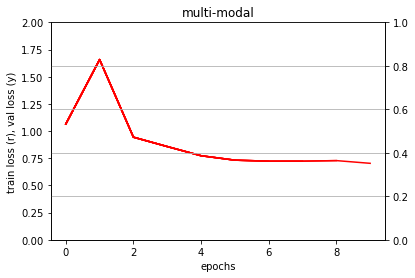

In [11]:
cudnn.benchmark = True

# Data loading code (pin_memory allows better transferring of samples to GPU memory)
train_dataset = Dataset(dataset_root, split_train, embedding_dimensionality)
val_dataset = Dataset(dataset_root, split_val, embedding_dimensionality)

train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True, 
                                           num_workers=workers, 
                                           pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset, 
                                         batch_size=batch_size, 
                                         shuffle=True, 
                                         num_workers=workers, 
                                         pin_memory=True)


# Plotting is not needed if we don't want to monitor training
# Also, standard monitoring tools such as Visom or Tensorflow could be used.
# Plotting config
plot_data = {}
plot_data['train_loss'] = zeros(epochs)
plot_data['val_loss'] = zeros(epochs)
plot_data['epoch'] = 0
it_axes = arange(epochs)
_, ax1 = subplots()
ax2 = ax1.twinx()
ax1.set_xlabel('epochs')
ax1.set_ylabel('train loss (r), val loss (y)')
ax1.set_ylim([0, 2])
best_loss = 1000


print("Dataset and model ready. Starting training ...")

for epoch in range(epochs):
    plot_data['epoch'] = epoch
    # Train for one epoch
    plot_data = train(train_loader, model, criterion, optimizer, epoch, print_freq, plot_data, gpu)
    # Evaluate on validation set
    plot_data = validate(val_loader, model, criterion, print_freq, plot_data, gpu)
    
    print(plot_data)


    if plot:

        ax1.plot(it_axes[0:epoch+1], plot_data['train_loss'][0:epoch+1], 'r')
        ax1.plot(it_axes[0:epoch+1], plot_data['val_loss'][0:epoch+1], 'y')
        plt.grid(True)
        plt.title(training_id)

        # Save graph to disk
        if epoch % 1 == 0 and epoch != 0:
            title = dataset_root +'training/' + training_id + '_epoch_' + str(epoch) + '.png'
            savefig(title, bbox_inches='tight')

print("Training completed for " + str(epochs) + " epochs.")
